In [1]:
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from scipy.stats import sem, t

def eval_std_ci(truth_df, hyps_df):
    evs_scores = []
    mae_scores = []
    mse_scores = []
    rmse_scores = []
    r2_scores = []
    fold_indices = [(0, 17), (17, 35), (35, 52), (52, 69), (69, 86)]

    for start, end in fold_indices:
        truth = np.array(truth_df[start:end])
        hyps = np.array(hyps_df[start:end])
        # hyps_binary = (hyps >= 0.5).astype(int)

        evs = explained_variance_score(truth, hyps)
        evs_scores.append(evs)
        mae = mean_absolute_error(truth, hyps)
        mae_scores.append(mae)
        mse = mean_squared_error(truth, hyps)
        mse_scores.append(mse)
        rmse = np.sqrt(mean_squared_error(truth, hyps))
        rmse_scores.append(rmse)
        r2 = r2_score(truth, hyps)
        r2_scores.append(r2)

    mean_evs = np.mean(evs_scores)
    std_evs = np.std(evs_scores)
    mean_mae = np.mean(mae_scores)
    std_mae = np.std(mae_scores)
    mean_mse = np.mean(mse_scores)
    std_mse = np.std(mse_scores)
    mean_rmse = np.mean(rmse_scores)
    std_rmse = np.std(rmse_scores)
    mean_r2 = np.mean(r2_scores)
    std_r2 = np.std(r2_scores)

    conf_interval_evs = t.interval(0.95, len(evs_scores)-1, loc=mean_evs, scale=std_evs/np.sqrt(len(evs_scores)))
    conf_interval_mae = t.interval(0.95, len(mae_scores)-1, loc=mean_mae, scale=std_mae/np.sqrt(len(mae_scores)))
    conf_interval_mse = t.interval(0.95, len(mse_scores)-1, loc=mean_mse, scale=std_mse/np.sqrt(len(mse_scores)))
    conf_interval_rmse = t.interval(0.95, len(rmse_scores)-1, loc=mean_rmse, scale=std_rmse/np.sqrt(len(rmse_scores)))
    conf_interval_r2 = t.interval(0.95, len(r2_scores)-1, loc=mean_r2, scale=std_r2/np.sqrt(len(r2_scores)))

    def adjust_confidence_interval(conf_interval):
        return (max(0, min(conf_interval[0], 1)), max(0, min(conf_interval[1], 1)))

    conf_interval_evs = adjust_confidence_interval(conf_interval_evs)
    conf_interval_mae = adjust_confidence_interval(conf_interval_mae)
    conf_interval_mse = adjust_confidence_interval(conf_interval_mse)
    conf_interval_rmse = adjust_confidence_interval(conf_interval_rmse)
    conf_interval_r2 = adjust_confidence_interval(conf_interval_r2)

    return evs_scores, mae_scores, mse_scores, rmse_scores, r2_scores, \
    mean_evs, mean_mae, mean_mse, mean_rmse, mean_r2, \
    std_evs, std_mae, std_mse, std_rmse, std_r2, \
    conf_interval_evs, conf_interval_mae, conf_interval_mse, conf_interval_rmse, conf_interval_r2

## eGeMAPS

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='0'
# os.environ['CUDA_VISIBLE_DEVICES']='0,1'
os.environ['CUDA_LAUNCH_BLOCKING']='1'
import torch
# torch.cuda.set_device(0)
print(torch.cuda.current_device())
#! python
# -*- coding: utf-8 -*-
# Author: kun
# @Time: 2019-10-29 20:29

import yaml
import argparse
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

class Para(object):
    a=1

def find_file(x):
        # return int(x.split('/')[-1].replace("CTT.wav", ""))
        return int(x.split('\\')[-1].replace("CTT.wav", ""))

def file_str(x):
    return int(x.replace("CTT", ""))

def find_5fold(x):
    return x[x.find("CTT5-")+5]
    
def force_cudnn_initialization():
    s = 32
    dev = torch.device('cuda:0')
    torch.nn.functional.conv2d(torch.zeros(s, s, s, s, device=dev), torch.zeros(s, s, s, s, device=dev))
    
#force_cudnn_initialization()
def main():
    # For reproducibility, comment these may speed up training
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    print("start")
    df1 = pd.read_csv('preprocess_input_CTT5_2_e_16.csv')
    df1['find_5fold'] = df1['file'].map(find_5fold)
    df1['file']=df1['file'].map(find_file)
    df1 = df1.sort_values(by='file', ascending=True)
    df1.set_index("file" , inplace=True)
    df3 = df1.iloc[:,-1]
    df1 = df1.drop(columns = ['start', 'end', 'find_5fold'])

    df2 = pd.read_csv('data/CDR.txt', sep=' ')
    df2['file']=df2['file'].map(file_str)
    df2.set_index("file" , inplace=True)

    feature = df1.to_numpy()
#     feature = torch.from_numpy(feature_numpy.astype(np.float32))

    target = df2.to_numpy()
#     target = torch.from_numpy(target_numpy.astype(np.float32))
#     target = target.view(target.shape[0], 1)

    n_samples, n_features = feature.shape
    print(n_samples, n_features)
    
    
    alldf =pd.DataFrame()
    for fold in range(0,5):
        # 5 fold
        train = []
        valid = []
        t_tra = []
        t_val = []
        name = []
        idx = 0
#         df =pd.DataFrame()
        for i in (df3.index):
            if(int(df3[i]) != fold+1):
                train.append(feature[idx])
                t_tra.append(target[idx])
            else:
                valid.append(feature[idx])
                t_val.append(target[idx])
                name.append(i)
            idx += 1

        train = np.array(train)
        train = torch.from_numpy(train.astype(np.float32))

        t_tra = np.array(t_tra)
        t_tra = torch.from_numpy(t_tra.astype(np.float32))
        t_tra = t_tra.view(t_tra.shape[0], 1)
        
        valid = np.array(valid)
        valid = torch.from_numpy(valid.astype(np.float32))

        t_val = np.array(t_val)
        t_val = torch.from_numpy(t_val.astype(np.float32))
        t_val = t_val.view(t_val.shape[0], 1)
        
        name = np.array(name)
        name = torch.from_numpy(name.astype(int))
        
        print("fold: ", fold)
        
        n_samples, n_features = train.shape
#         print(n_samples, n_features)
        n_samples, n_features = valid.shape
#         print(n_samples, n_features)

        regr = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))

        # Fit the model to the data
        regr.fit(train, t_tra.ravel())
#         print(reg.coef_)
        y_predicted = regr.predict(train)
#         loss = mean_squared_error(t_tra, y_predicted)
        y_predicted_val = regr.predict(valid)
#         loss_val = mean_squared_error(t_val, y_predicted_val)
#         print("loss ", loss, "loss_val", loss_val)
        
#         print(t_val.ravel())
        y_predicted_val = torch.from_numpy(y_predicted_val.astype(np.float32))
        y_predicted_val = y_predicted_val.view(y_predicted_val.shape[0], 1)
#         print(y_predicted_val.ravel())
        df = pd.DataFrame(
            {'name': name,
             'hyps': torch.flatten(y_predicted_val).detach().numpy(),
             'truth': torch.flatten(t_val).detach().numpy()
            })
        alldf = pd.concat([alldf, df])#
        # df.to_csv(f'CDR_result/5folds_CDR_{fold+1}_acoustic_e.csv', index=False)
    alldf.to_csv(f'CDR_result/acoustic_e.csv', index=False) 
    return True


0


In [2]:
# res = False
# import time
# while (res == False):
# #     print(res)
#     time.sleep(2)
#     try:
#         res = main()
#     except:
#         continue
main()

start
86 88
fold:  0
fold:  1
fold:  2
fold:  3
fold:  4


True

In [2]:
import pandas as pd
fivefolds_1k_e = pd.read_csv('CDR_result/acoustic_e.csv')
# fivefolds_1k['result'] = np.where(fivefolds_1k['hyps'] >= 0.5,1,0)
fivefolds_1k_e.head(50)

,name,hyps,truth
0,15,0.212737,0.0
1,16,0.409953,0.5
2,22,0.203951,0.0
3,28,0.318456,0.5
4,34,0.191578,0.0
5,35,0.243950,0.5
6,40,0.700031,0.5
7,42,0.178757,0.0
8,51,0.212288,0.0
9,53,0.295054,0.0


In [3]:
fivefolds_1k_e.tail(36)

,name,hyps,truth
50,93,0.269980,0.0
51,98,0.185528,0.0
52,4,0.238119,0.5
53,6,0.222241,0.0
54,7,0.238119,0.0
55,9,0.270524,2.0
56,12,0.243009,0.5
57,17,0.238119,0.5
58,21,0.185484,0.0
59,29,0.233952,0.0


In [4]:
# fivefolds_1k = fivefolds_1k.drop([24])

In [5]:
# fivefolds_1_result = fivefolds_1k['result'].tolist()
fivefolds_1_hyps_e = fivefolds_1k_e['hyps'].tolist()
# fivefolds_1_truth = [int(i) for i in fivefolds_1k['truth'].tolist()]
fivefolds_1_truth_e = fivefolds_1k_e['truth'].tolist()

In [8]:
import pandas as pd
from sklearn import metrics
print('mae: ', metrics.mean_absolute_error(fivefolds_1_truth_e, fivefolds_1_hyps_e))
print('mse: ', metrics.mean_squared_error(fivefolds_1_truth_e, fivefolds_1_hyps_e))
print('rmse: ', np.sqrt(metrics.mean_squared_error(fivefolds_1_truth_e, fivefolds_1_hyps_e)))
print('r2: ', metrics.r2_score(fivefolds_1_truth_e, fivefolds_1_hyps_e))
print('evs: ', metrics.explained_variance_score(fivefolds_1_truth_e, fivefolds_1_hyps_e))

evs_scores, mae_scores, mse_scores, rmse_scores, r2_scores, \
mean_evs, mean_mae, mean_mse, mean_rmse, mean_r2, \
std_evs, std_mae, std_mse, std_rmse, std_r2, \
conf_interval_evs, conf_interval_mae, conf_interval_mse, conf_interval_rmse, conf_interval_r2 = eval_std_ci(fivefolds_1_truth_e, fivefolds_1_hyps_e)
print(f"EVS Scores: {evs_scores}, MAE Scores: {mae_scores}, MSE Scores: {mse_scores}, RMSE Scores: {rmse_scores}, R2 Scores: {r2_scores}")
print(f"Mean MAE Scores: {mean_mae}, Std Dev: {std_mae}, 95% Confidence Interval: {conf_interval_mae}")
print(f"Mean MSE Scores: {mean_mse}, Std Dev: {std_mse}, 95% Confidence Interval: {conf_interval_mse}")
print(f"Mean RMSE Scores: {mean_rmse}, Std Dev: {std_rmse}, 95% Confidence Interval: {conf_interval_rmse}")
print(f"Mean R2: {mean_r2}, Std Dev: {std_r2}, 95% Confidence Interval: {conf_interval_r2}")
print(f"Mean EVS Score: {mean_evs}, Std Dev: {std_evs}, 95% Confidence Interval: {conf_interval_evs}")

mae:  0.2369398985697674
mse:  0.09235794586562923
rmse:  0.30390450122633794
r2:  0.11974308296109026
evs:  0.16292880926197184
EVS Scores: [0.4510111233522346, 0.17386485106366, 0.4114033774189211, 0.0614424838477704, 0.20814662089308944], MAE Scores: [0.21474803411764706, 0.22487494094444443, 0.18912996352941178, 0.31231717000000003, 0.2443390876470588], MSE Scores: [0.04800389865716082, 0.07545693312093654, 0.04099283196390588, 0.22427548094229724, 0.0740547618641217], RMSE Scores: [0.21909792024836935, 0.2746942538913702, 0.2024668663359659, 0.47357732308705114, 0.27213004586800355], R2 Scores: [-0.06716359322457532, 0.15696391961436407, 0.2820043371170423, 0.060643275473566405, 0.1439269528507532]
Mean MAE Scores: 0.23708183924771245, Std Dev: 0.04161781409544077, 95% Confidence Interval: (0.1854064978014664, 0.2887571806939585)
Mean MSE Scores: 0.09255678130968444, Std Dev: 0.06727309356545487, 95% Confidence Interval: (0.009026202981665662, 0.17608735963770322)
Mean RMSE Scores

<Axes: xlabel='truth', ylabel='hyps'>

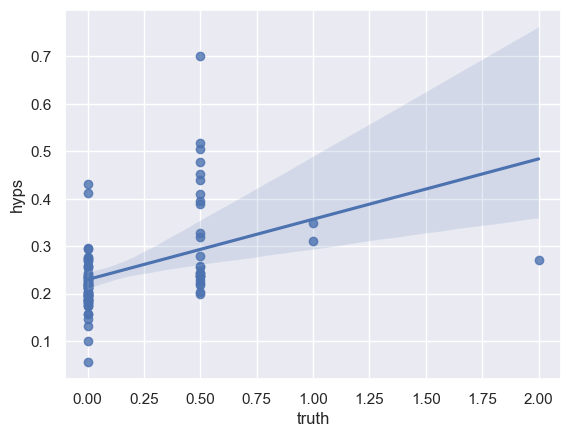

In [8]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.set_theme(color_codes=True)
tips = sns.load_dataset("tips")
sns.regplot(x="truth", y="hyps", data=fivefolds_1k_e)

## ComParE

In [9]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='0'
# os.environ['CUDA_VISIBLE_DEVICES']='0,1'
os.environ['CUDA_LAUNCH_BLOCKING']='1'
import torch
# torch.cuda.set_device(0)
print(torch.cuda.current_device())
#! python
# -*- coding: utf-8 -*-
# Author: kun
# @Time: 2019-10-29 20:29

import yaml
import argparse
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

class Para(object):
    a=1

def find_file(x):
        # return int(x.split('/')[-1].replace("CTT.wav", ""))
        return int(x.split('\\')[-1].replace("CTT.wav", ""))

def file_str(x):
    return int(x.replace("CTT", ""))

def find_5fold(x):
    return x[x.find("CTT5-")+5]
    
def force_cudnn_initialization():
    s = 32
    dev = torch.device('cuda:0')
    torch.nn.functional.conv2d(torch.zeros(s, s, s, s, device=dev), torch.zeros(s, s, s, s, device=dev))
    
#force_cudnn_initialization()
def main():
    # For reproducibility, comment these may speed up training
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    print("start")
    df1 = pd.read_csv('preprocess_input_CTT5_2_c_16.csv')
    df1['find_5fold'] = df1['file'].map(find_5fold)
    df1['file']=df1['file'].map(find_file)
    df1 = df1.sort_values(by='file', ascending=True)
    df1.set_index("file" , inplace=True)
    df3 = df1.iloc[:,-1]
    df1 = df1.drop(columns = ['start', 'end', 'find_5fold'])

    df2 = pd.read_csv('data/CDR.txt', sep=' ')
    df2['file']=df2['file'].map(file_str)
    df2.set_index("file" , inplace=True)

    feature = df1.to_numpy()
#     feature = torch.from_numpy(feature_numpy.astype(np.float32))

    target = df2.to_numpy()
#     target = torch.from_numpy(target_numpy.astype(np.float32))
#     target = target.view(target.shape[0], 1)

    n_samples, n_features = feature.shape
    print(n_samples, n_features)
    
    
    alldf =pd.DataFrame()
    for fold in range(0,5):
        # 5 fold
        train = []
        valid = []
        t_tra = []
        t_val = []
        name = []
        idx = 0
#         df =pd.DataFrame()
        for i in (df3.index):
            if(int(df3[i]) != fold+1):
                train.append(feature[idx])
                t_tra.append(target[idx])
            else:
                valid.append(feature[idx])
                t_val.append(target[idx])
                name.append(i)
            idx += 1

        train = np.array(train)
        train = torch.from_numpy(train.astype(np.float32))

        t_tra = np.array(t_tra)
        t_tra = torch.from_numpy(t_tra.astype(np.float32))
        t_tra = t_tra.view(t_tra.shape[0], 1)
        
        valid = np.array(valid)
        valid = torch.from_numpy(valid.astype(np.float32))

        t_val = np.array(t_val)
        t_val = torch.from_numpy(t_val.astype(np.float32))
        t_val = t_val.view(t_val.shape[0], 1)
        
        name = np.array(name)
        name = torch.from_numpy(name.astype(int))
        
        print("fold: ", fold)
        
        n_samples, n_features = train.shape
#         print(n_samples, n_features)
        n_samples, n_features = valid.shape
#         print(n_samples, n_features)

        regr = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))

        # Fit the model to the data
        regr.fit(train, t_tra.ravel())
#         print(reg.coef_)
        y_predicted = regr.predict(train)
#         loss = mean_squared_error(t_tra, y_predicted)
        y_predicted_val = regr.predict(valid)
#         loss_val = mean_squared_error(t_val, y_predicted_val)
#         print("loss ", loss, "loss_val", loss_val)
        
#         print(t_val.ravel())
        y_predicted_val = torch.from_numpy(y_predicted_val.astype(np.float32))
        y_predicted_val = y_predicted_val.view(y_predicted_val.shape[0], 1)
#         print(y_predicted_val.ravel())
        df = pd.DataFrame(
            {'name': name,
             'hyps': torch.flatten(y_predicted_val).detach().numpy(),
             'truth': torch.flatten(t_val).detach().numpy()
            })
        alldf = pd.concat([alldf, df])
        # df.to_csv(f'./CDR_result/5folds_CDR_{fold+1}_acoustic_c.csv', index=False)
    alldf.to_csv(f'./CDR_result/acoustic_c.csv', index=False) 
    return True


0


In [10]:
main()

start
86 6373
fold:  0
fold:  1
fold:  2
fold:  3
fold:  4


True

In [10]:
fivefolds_1k_c = pd.read_csv('CDR_result/acoustic_c.csv')
# fivefolds_1k['result'] = np.where(fivefolds_1k['hyps'] >= 0.5,1,0)
fivefolds_1k_c.head(50)

,name,hyps,truth
0,15,0.220775,0.0
1,16,0.343849,0.5
2,22,0.198552,0.0
3,28,0.300890,0.5
4,34,0.261931,0.0
5,35,0.298887,0.5
6,40,0.404889,0.5
7,42,0.208316,0.0
8,51,0.283013,0.0
9,53,0.298048,0.0


In [11]:
fivefolds_1k_c.tail(36)

,name,hyps,truth
50,93,0.198754,0.0
51,98,0.235659,0.0
52,4,0.228544,0.5
53,6,0.229033,0.0
54,7,0.217743,0.0
55,9,0.220451,2.0
56,12,0.323747,0.5
57,17,0.338676,0.5
58,21,0.258055,0.0
59,29,0.204448,0.0


In [12]:
# fivefolds_1_result = fivefolds_1k['result'].tolist()
fivefolds_1_hyps_c = fivefolds_1k_c['hyps'].tolist()
# fivefolds_1_truth = [int(i) for i in fivefolds_1k['truth'].tolist()]
fivefolds_1_truth_c = fivefolds_1k_c['truth'].tolist()

In [13]:
from sklearn import metrics
print('mae: ', metrics.mean_absolute_error(fivefolds_1_truth_c, fivefolds_1_hyps_c))
print('mse: ', metrics.mean_squared_error(fivefolds_1_truth_c, fivefolds_1_hyps_c))
print('rmse: ', np.sqrt(metrics.mean_squared_error(fivefolds_1_truth_c, fivefolds_1_hyps_c)))
print('r2: ', metrics.r2_score(fivefolds_1_truth_c, fivefolds_1_hyps_c))
print('evs: ', metrics.explained_variance_score(fivefolds_1_truth_c, fivefolds_1_hyps_c))

evs_scores, mae_scores, mse_scores, rmse_scores, r2_scores, \
mean_evs, mean_mae, mean_mse, mean_rmse, mean_r2, \
std_evs, std_mae, std_mse, std_rmse, std_r2, \
conf_interval_evs, conf_interval_mae, conf_interval_mse, conf_interval_rmse, conf_interval_r2 = eval_std_ci(fivefolds_1_truth_c, fivefolds_1_hyps_c)
print(f"EVS Scores: {evs_scores}, MAE Scores: {mae_scores}, MSE Scores: {mse_scores}, RMSE Scores: {rmse_scores}, R2 Scores: {r2_scores}")
print(f"Mean MAE Scores: {mean_mae}, Std Dev: {std_mae}, 95% Confidence Interval: {conf_interval_mae}")
print(f"Mean MSE Scores: {mean_mse}, Std Dev: {std_mse}, 95% Confidence Interval: {conf_interval_mse}")
print(f"Mean RMSE Scores: {mean_rmse}, Std Dev: {std_rmse}, 95% Confidence Interval: {conf_interval_rmse}")
print(f"Mean R2: {mean_r2}, Std Dev: {std_r2}, 95% Confidence Interval: {conf_interval_r2}")
print(f"Mean EVS Score: {mean_evs}, Std Dev: {std_evs}, 95% Confidence Interval: {conf_interval_evs}")

mae:  0.26575696441860464
mse:  0.105346662293208
rmse:  0.3245715056704886
r2:  -0.004051435980111373
evs:  0.04543258465462996
EVS Scores: [0.2333140459766201, 0.07250960420827035, 0.13557778250609331, 0.023003988498115246, 0.005179665146876622], MAE Scores: [0.23816523470588233, 0.2656624344444445, 0.22743201176470587, 0.31247812705882355, 0.28505257470588236], MSE Scores: [0.06057626845257594, 0.0847177449067042, 0.053598225720448825, 0.23328146510186745, 0.09577307301306154], RMSE Scores: [0.24612246637106483, 0.29106312873104384, 0.23151290616388717, 0.4829921998354295, 0.30947224918086197], R2 Scores: [-0.3466570448303421, 0.05349829828371866, 0.061218955563047794, 0.0229225592110186, -0.10713672403099128]
Mean MAE Scores: 0.2657580765359477, Std Dev: 0.03093639309618295, 95% Confidence Interval: (0.22734547099413777, 0.3041706820777576)
Mean MSE Scores: 0.1055893554389316, Std Dev: 0.06567573976209175, 95% Confidence Interval: (0.02404215382094267, 0.1871365570569205)
Mean RMSE

<Axes: xlabel='truth', ylabel='hyps'>

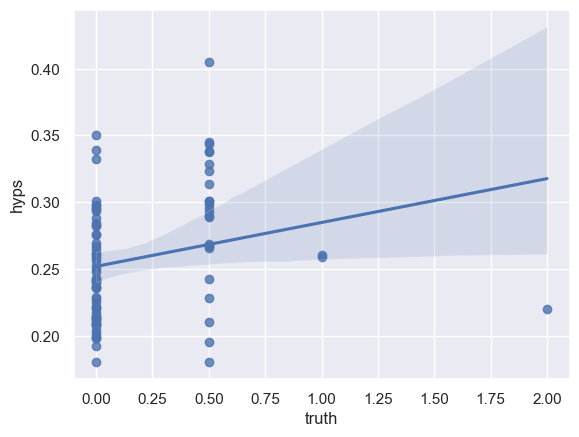

In [15]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.set_theme(color_codes=True)
tips = sns.load_dataset("tips")
sns.regplot(x="truth", y="hyps", data=fivefolds_1k_c)